In [2]:
import pandas as pd
import numpy as np
import os
import math
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted")
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score, precision_score, recall_score

# Một Số Hàm Viết Sẵn

In [81]:
def func(pct, allvalues):
    absolute = int(pct / 100*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

In [83]:
def pie(df_final, numbers):
    l = df_final.value_counts()[df_final.unique()].sort_values(ascending=False)
    circle = []
    columns = []
    others = 0
    for i in l:
        if len(circle) == numbers:
            others += i 
        else:
            circle.append(i)
            columns.append(l[l == i].index[0])
    if len(circle) == numbers and len(circle) != len(df_final.unique()) : 
        circle.append(others)
        columns.append('Others')

    wp = { 'linewidth' : 1, 'edgecolor' : "green" }
    #explode = (0.1, 0.0, 0.2, 0.3)
    explode = np.arange(0,len(columns)/10,0.1)

    #fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10),facecolor=(1, 1, 1))
    fig, ax = plt.subplots(figsize =(10, 7),facecolor=(1, 1, 1))

    #plt.subplot(1,2,1)
    #plt.pie(circle, labels = columns ,autopct='%1.1f%%',radius=1,startangle = 90,wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
    wedges, texts, autotexts = ax.pie(circle,
                                  autopct = lambda pct: func(pct, circle),
                                  explode = explode,
                                  labels = columns,
                                  shadow = True,
                                  
                                  startangle = 90,
                                  wedgeprops = wp,
                                  
                                  )


    plt.setp(autotexts, size = 13, weight ="bold")
    plt.show()

In [84]:
def ve_bieu_do_cot(label,value):
    fig, ax = plt.subplots(figsize =(10, 8))
  
    plt.bar(label,value,width = 0.4)
    plt.xlabel("Attributes")
    plt.ylabel("Counts")
    for i in ax.patches:
        plt.text(i.get_x()+ i.get_width()/3, i.get_height()+20,
             str(i.get_height()),
             fontsize = 13, fontweight ='bold',
             color ='black')
    plt.show()

In [85]:
def countplot(df1,label):
    fig, ax = plt.subplots(figsize =(20, 10),facecolor=(1, 1, 1))

    ax = sns.countplot(df1['Label'],data = df1,hue = df1[label],palette = "bwr",edgecolor = 'black')
    
    for rect in ax.patches:
        if math.isnan(rect.get_height()) : continue
        
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, int(rect.get_height()), horizontalalignment='center', fontsize = 11)



In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
def K_fold(xtrain, ytrain, estimator):
    fold_k = StratifiedKFold(n_splits = 20).split(xtrain, ytrain)
    xtrain_f, xvalid_f,ytrain_f, yvalid_f = [], [], [], []
    for k , (train, valid) in enumerate(fold_k):
        xtrain_f.append(xtrain[train]), xvalid_f.append(xtrain[valid])
        ytrain_f.append(ytrain[train]), yvalid_f.append(ytrain[valid])
        estimator.fit(xtrain[train], ytrain[train])
        st = 'k: {}, train acc: {}, and validation acc: {}'.format(k, estimator.score(xtrain[train], ytrain[train]),
                                                           estimator.score(xtrain[valid], ytrain[valid]))
        print(st)
    return xtrain_f, xvalid_f,ytrain_f, yvalid_f

In [7]:
class Logistic:
    def __init__(self):
        self.model =  make_pipeline(
                        RobustScaler(),
                        KernelPCA(kernel = 'rbf', n_components = 20),
                        LogisticRegression(solver = 'lbfgs',C = 100, random_state = 1, multi_class = 'ovr',
                        class_weight = 'balanced', max_iter = 3000)
        )   
    def grid_search(self,xtrain, ytrain):
        logisticregression_search = GridSearchCV(
                                        scoring = 'accuracy', 
                                        estimator = self.model,
                                        param_grid = [{
                                            'logisticregression__solver': ['lbfgs', 'liblinear'],
                                            'logisticregression__C': [0.001, 0.01, 0.1]
                                        }],
                                        cv = 10)
        logisticregression_search.fit(xtrain, ytrain)
        self.model = logisticregression_search.best_estimator_
    def kfold(self,xtrain,ytrain):
        xtrain_f, xvalid_f,ytrain_f, yvalid_f = K_fold(xtrain, ytrain, self.model)
    def predict(self,xtest):
        return self.model.predict(xtest)
        

In [26]:
class SVM:
    def __init__(self):
        self.model = make_pipeline(
                            RobustScaler(),
                            KernelPCA(n_components = 12, kernel = 'rbf'),
                            SVC(kernel = 'rbf', gamma = 5, C = 100, 
                               random_state = 1, probability=True)
        )   
    def grid_search(self,xtrain, ytrain):
        search = GridSearchCV(
                              estimator = self.model, 
                              param_grid = [{
                                  'svc__kernel': ['rbf', 'linear'],
                                  'svc__C': [0.001, 0.01, 0.1],
                                  'svc__gamma': [0.001, 0.01, 0.1]
                                  
                              }],
                              scoring = 'accuracy', cv = 10)
        search.fit(xtrain, ytrain)
        self.model = search.best_estimator_
    def kfold(self,xtrain,ytrain):
        xtrain_f, xvalid_f,ytrain_f, yvalid_f = K_fold(xtrain, ytrain, self.model)
    def predict(self,xtest):
        return self.model.predict(xtest)

In [27]:
class Adaboost:
    def __init__(self):
        self.model =  None
    def grid_search(self,xtrain, ytrain):
        search_for_best = GridSearchCV(estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=1), 
                              param_grid = [{
                                  "base_estimator__criterion" : ["gini", "entropy"],
                                  'n_estimators': [10, 50, 100, 500],
                                  'learning_rate': [0.001, 0.01, 0.1]
                                  
                              }],
                              scoring = 'accuracy', cv = 10)
        search_for_best.fit(xtrain, ytrain)
        self.model = search_for_best.best_estimator_
    def kfold(self,xtrain,ytrain):
        xtrain_f, xvalid_f,ytrain_f, yvalid_f = K_fold(xtrain, ytrain, self.model)
    def predict(self,xtest):
        return self.model.predict(xtest)

In [28]:
class MLP:
    def __init__(self):
        self.model =  None
    def grid_search(self,xtrain, ytrain):
        search_for_best = GridSearchCV(estimator = MLPClassifier(max_iter=800, random_state = 1, early_stopping=True), 
                              param_grid = [{
                                  'solver' : ['lbfgs', 'sgd', 'adam'],
                                  'activation':['identity', 'logistic', 'tanh', 'relu'],
                                  'learning_rate_init': [0.001, 0.01, 0.1]
                                  
                              }],
                              scoring = 'accuracy', cv = 10)
        search_for_best.fit(xtrain, ytrain)
        self.model = search_for_best.best_estimator_
    def kfold(self,xtrain,ytrain):
        xtrain_f, xvalid_f,ytrain_f, yvalid_f = K_fold(xtrain, ytrain, self.model)
    def predict(self,xtest):
        return self.model.predict(xtest)

# Data Khi Sinh Viên Chỉ Mới Thi Anh Văn Đầu Vào


## Phân tích Data

In [86]:
wb = openpyxl.load_workbook('./data_final.xlsx',keep_vba=True, data_only=True)
sheet = wb[wb.sheetnames[0]]
df1 = pd.DataFrame(data=sheet.values)
df1.columns = df1.iloc[0]
df1 = df1[1:]
df1 = df1.drop(columns=['mssv','chuanav_1'])

In [87]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4916 entries, 1 to 4916
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   namsinh   4916 non-null   object
 1   gioitinh  4916 non-null   object
 2   khoa      4916 non-null   object
 3   hedt      4916 non-null   object
 4   khoahoc   4916 non-null   object
 5   mamh      4916 non-null   object
 6   dien_tt   4916 non-null   object
 7   khu_vuc   4916 non-null   object
 8   Label     4916 non-null   object
dtypes: object(9)
memory usage: 345.8+ KB


### Transform các cột dữ liệu

In [113]:
df1_copy = df1.copy(deep = True)

### Thống Kê Label Của Dataset

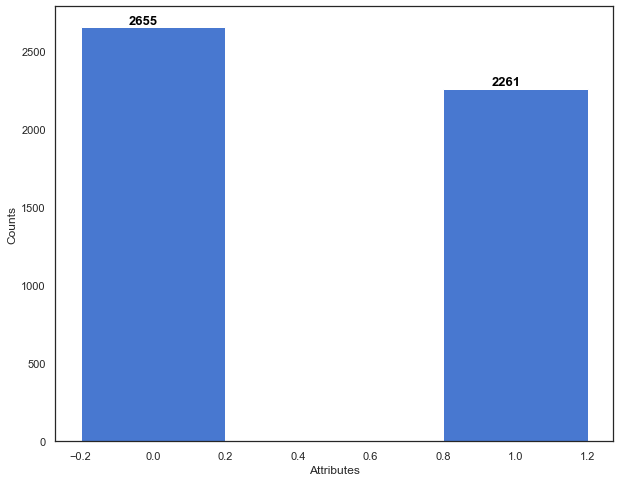

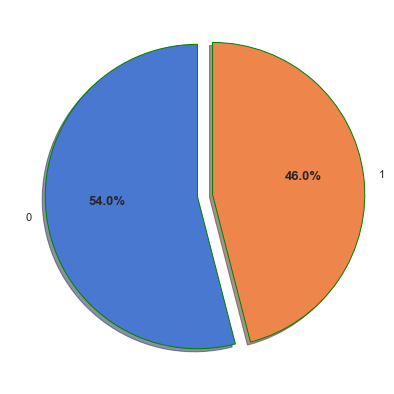

In [89]:
ve_bieu_do_cot(df1_copy['Label'].value_counts().index, df1_copy['Label'].value_counts())
pie(df1_copy['Label'],2)

Dữ liệu khá cân bằng giữa 2 label 1 và 0. Vì vậy ta không cần sử dụng những kĩ thuật cân bằng dữ liệu.

### Sự Ảnh Hưởng Của Anh Văn Đầu Vào ( thuộc tính mamh )

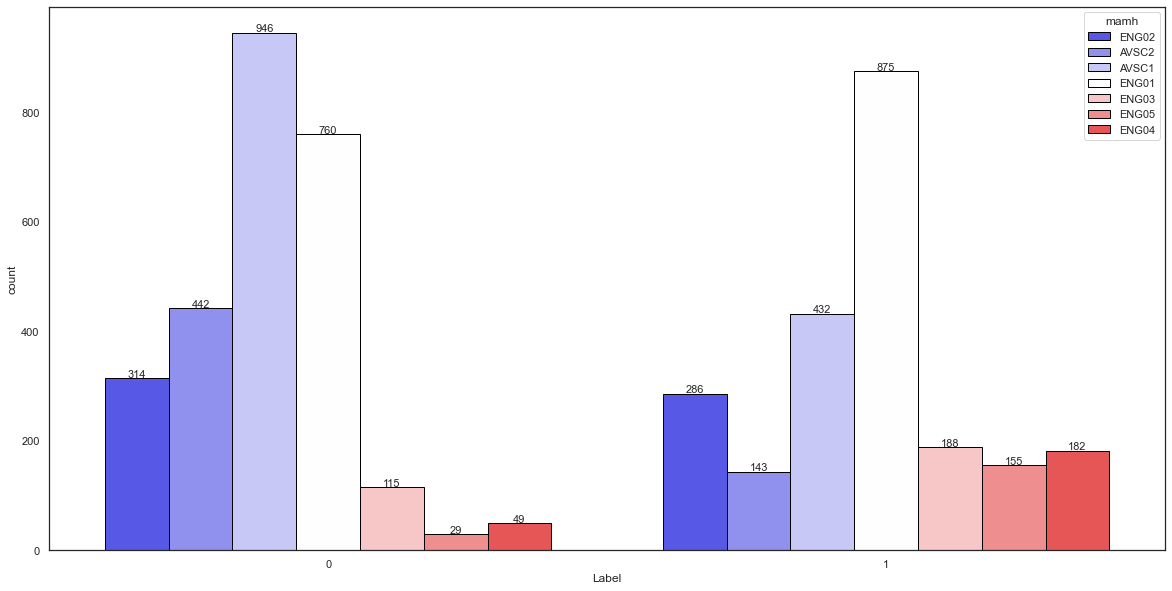

In [90]:
countplot(df1_copy,"mamh")

Dựa vào biểu đồ ta thấy rằng:
- AVSC1[0] / AVSC1[1]  = 2.2
- AVSC2[0] / AVSC2[1]  = 3
- ENG01[0] / ENG01[1] = 0.87
- ENG02[0] / ENG02[1] = 1.1
- ENG03[0] / ENG03[1] = 0.61
- Tỉ lệ ENG04, ENG05 đều bé hơn 1

Từ đó ta thấy rằng, sinh viên khi thi đầu vào được AVSC1, AVSC2 thường sẽ không đạt chuẩn quá trình lớn hơn các mức anh văn khác.


### Sự Ảnh Hưởng Của Năm Sinh ( thuộc tính namsinh )

In [91]:
df1_copy['namsinh'].value_counts()

2001    1471
2000    1271
1999    1058
1998     937
1997     124
1996      33
1995      15
1992       3
1993       1
1994       1
1991       1
1988       1
Name: namsinh, dtype: int64

Thuộc tính năm sinh gồm rất nhiều giá trị, tuy nhiên, từ 1988 -> 1997 có số lượng rất ít. Nên để thuận tiện cho việc visualize, ta sẽ gom nhóm này lại là Others.

In [92]:
df1_copy.loc[(df1_copy["namsinh" ] != 1998) &  (df1_copy["namsinh" ] != 1999) & (df1_copy["namsinh" ] !=2000) & (df1_copy["namsinh" ] !=2001),"namsinh" ] = 1997

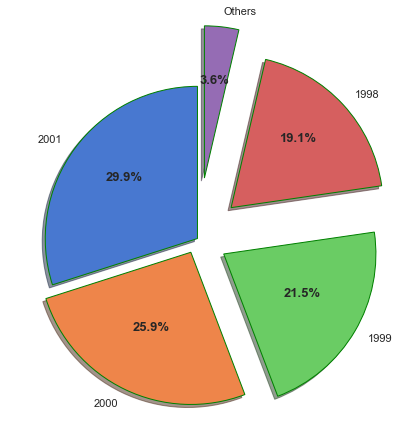

In [93]:
pie(df1_copy['namsinh'],4)

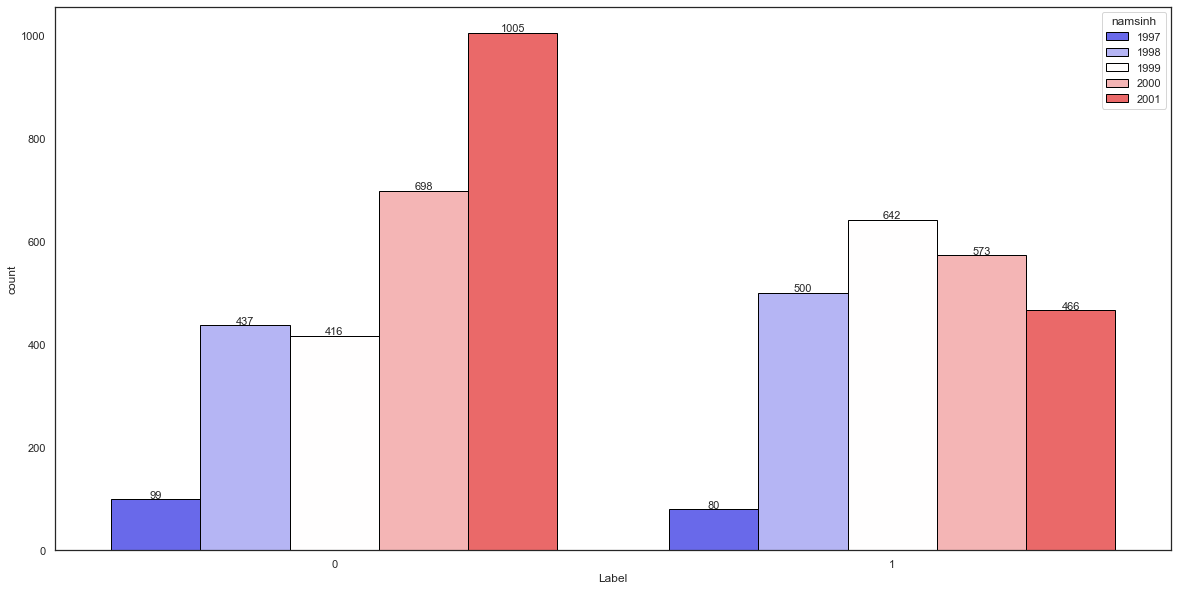

In [94]:
countplot(df1_copy,"namsinh")

Những sinh viên có số tuổi nhỏ (2001-2000) thông thường vẫn chưa đủ chuẩn quá trình. Có thể lí do là sinh viên vẫn còn đang học năm 1,2 nên vẫn chưa cần xét chuẩn quá trình.

### Hệ Đào Tạo

In [96]:
df1_copy['hedt'].value_counts()

CQUI    2683
CLC     1858
CTTT     180
KSTN     101
CNTN      94
Name: hedt, dtype: int64

Có 5 hệ đào tạo khác nhau. Tuy nhiên, dựa theo quy định, ta có thể gom CQUI, KSTN, CNTN thành 1 nhóm do có cùng chuẩn anh văn như nhau và CLC, CTTT thành một nhóm. Kể từ đây khi nói đến hệ CQUI tức là đề cập đến cả nhóm hệ CQUI, KSTN, CNTN. Tương tự với hệ CLC.

In [97]:
df1_copy.loc[(df1_copy["hedt"] == "KSTN") |  (df1_copy["hedt" ] == "CNTN"),"hedt" ] = "CQUI"
df1_copy.loc[(df1_copy["hedt"] == "CTTT"),"hedt" ] = "CLC"

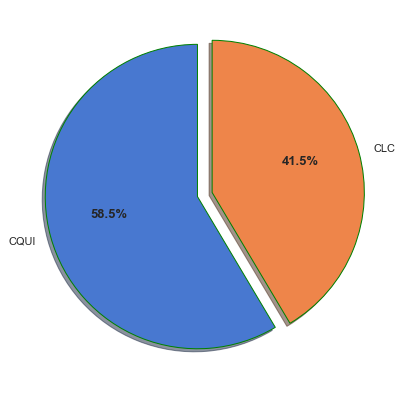

In [98]:
pie(df1_copy['hedt'],2)

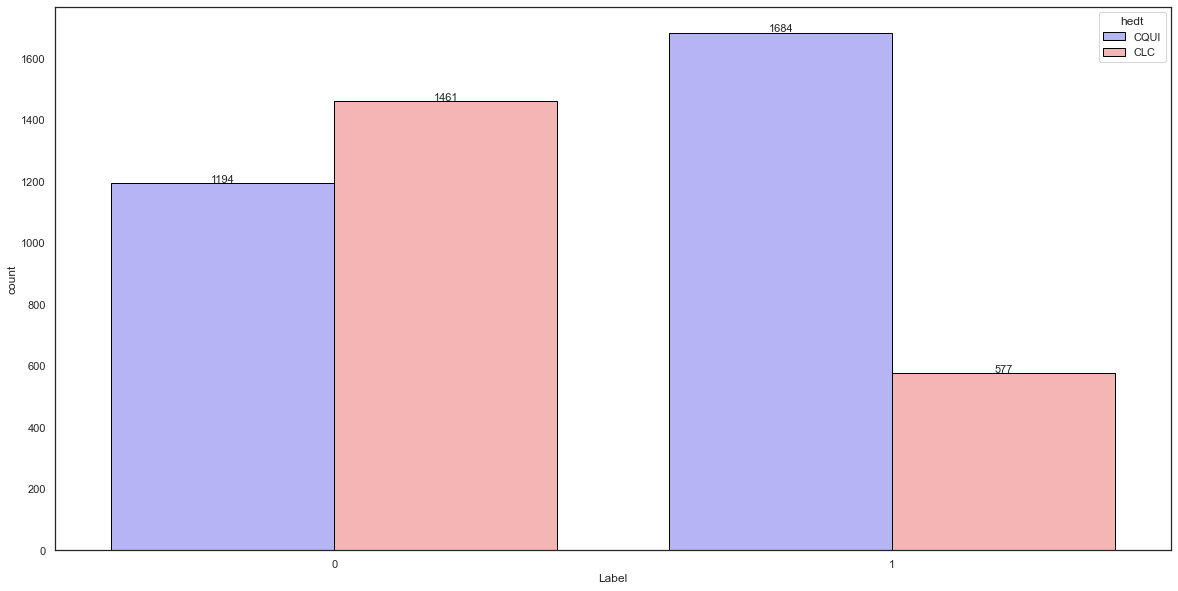

In [99]:
countplot(df1_copy,"hedt")

Hệ ClC có tỉ lệ sinh viên không đạt chuẩn quá trình nhiều gấp đôi hệ CQUI do ngưỡng AV để đạt chuẩn cao hơn hệ CQUI 

### Mối Quan Hệ Giữa Hệ Đào Tạo Và Anh Văn Đầu Vào

In [100]:
df1_copy['mamh']

1       ENG02
2       AVSC2
3       AVSC1
4       AVSC1
5       AVSC2
        ...  
4912    AVSC1
4913    AVSC1
4914    AVSC1
4915    AVSC2
4916    AVSC1
Name: mamh, Length: 4916, dtype: object

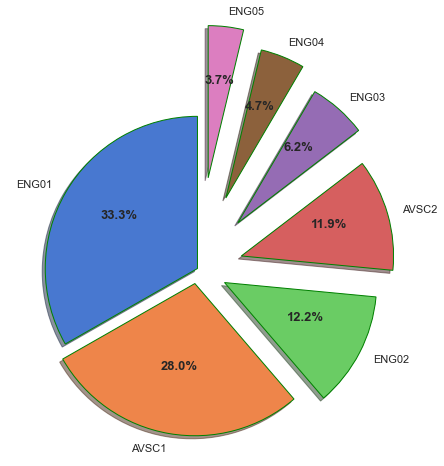

In [101]:
pie(df1_copy['mamh'],7)

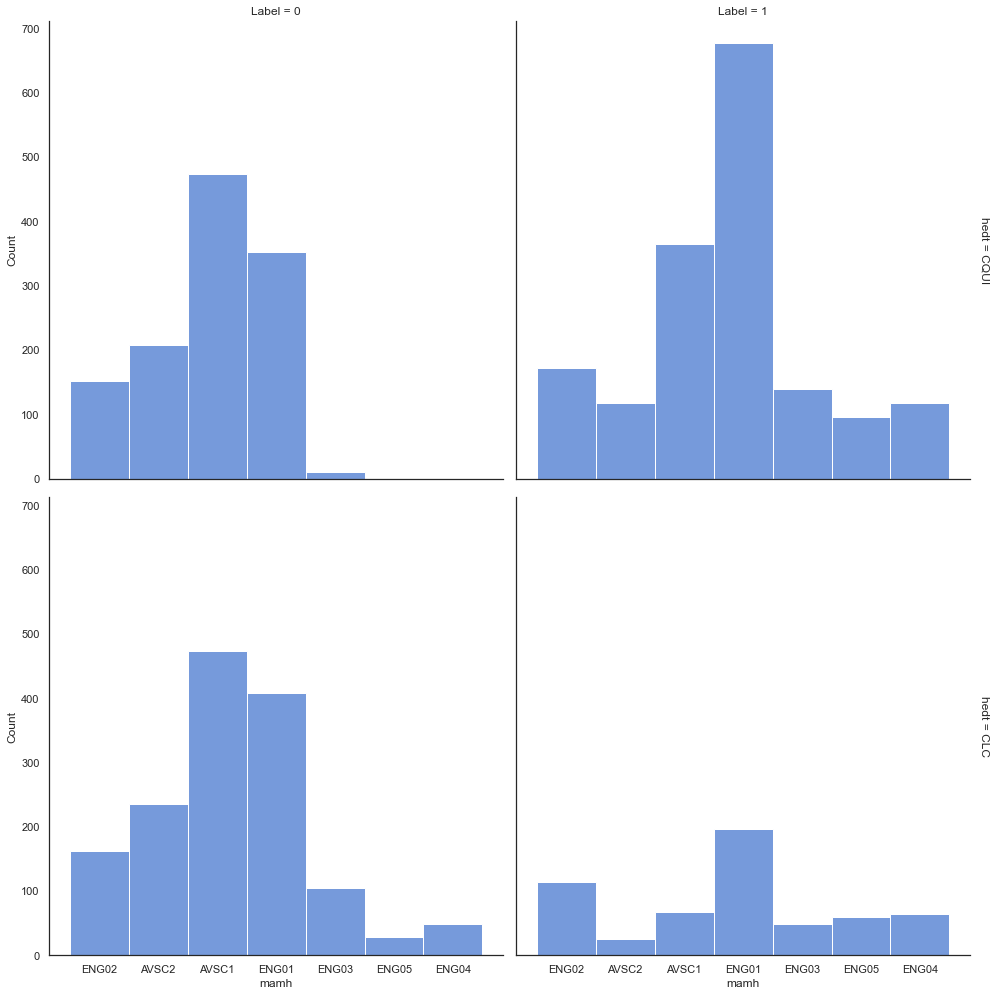

In [102]:
sns.displot(
    df1_copy, x="mamh", col="Label", row="hedt",
    binwidth=3, height=7, facet_kws=dict(margin_titles=True),
)

Đối với hệ chính qui: khi thi anh văn đầu vào đạt ENG04 và ENG05 thì chắc chắn sẽ đạt chuẩn quá trình, ENG03 cũng rất cao khi sinh viên thi vừa chạm ngưỡng để xét.
Dối với hệ CLC: sinh viên khi thi AVSC1, AVSC2 đa số sẽ không thể đạt chuẩn quá trình.

### Diện xét tuyển vào trường

In [103]:
df1_copy["dien_tt"].value_counts()

THPT       4190
ĐGNL        351
ƯT-ĐHQG     288
TT-Bộ        42
CUTUYEN      22
ƯT-Bộ        20
30A           2
CCQT          1
Name: dien_tt, dtype: int64

Thuộc tính diện xét tuyển gồm rất nhiều giá trị khác nhau. Ta sẽ gom thành 4 nhóm chính: THPT, ĐGNL, ƯT-ĐHQG, Others.

In [104]:
df1_copy.loc[(df1_copy["dien_tt" ] != "THPT") &  (df1_copy["dien_tt" ] != "ĐGNL") & (df1_copy["dien_tt" ] != "ƯT-ĐHQG") ,"dien_tt" ] = "Others"

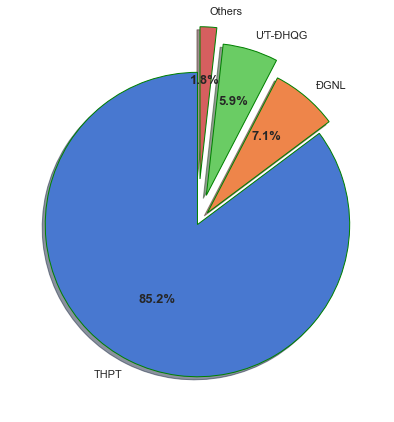

In [105]:
pie(df1_copy['dien_tt'],4)

Phần lớn sinh viên xét tuyển vào trường bằng hình thức thi THPT

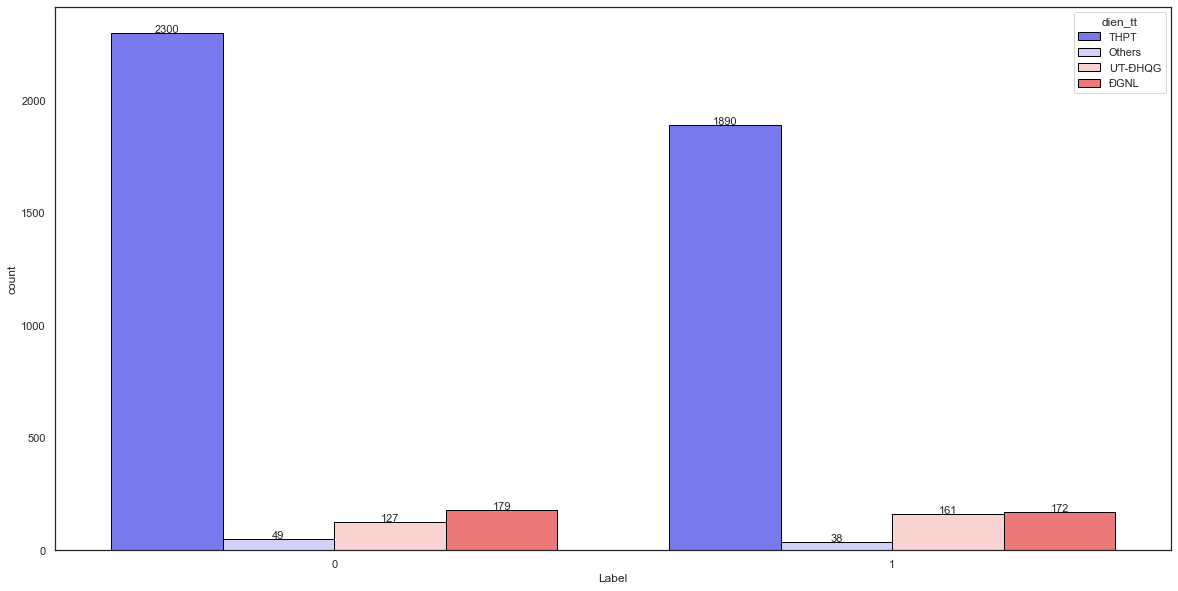

In [106]:
countplot(df1_copy,"dien_tt")

Nhìn vào đồ thị có thể thấy rõ là không có sự chênh lệch giữa các diện xét tuyển, tức là tỉ lệ thuộc mỗi class là như nhau. Điều này cho thấy rằng có thể diện xét tuyển không ảnh hưởng nhiều đến chuẩn quá trình của các sinh viên.

### Khu vực

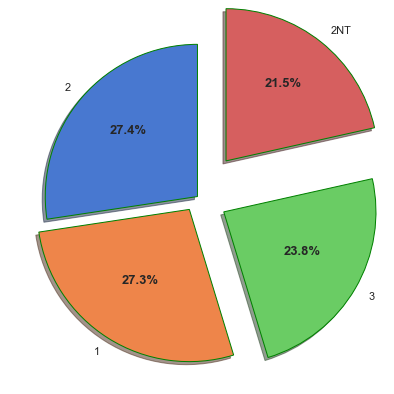

In [76]:
pie(df1_copy['khu_vuc'],4)

Tỉ lệ các khu vực cân bằng với nhau.

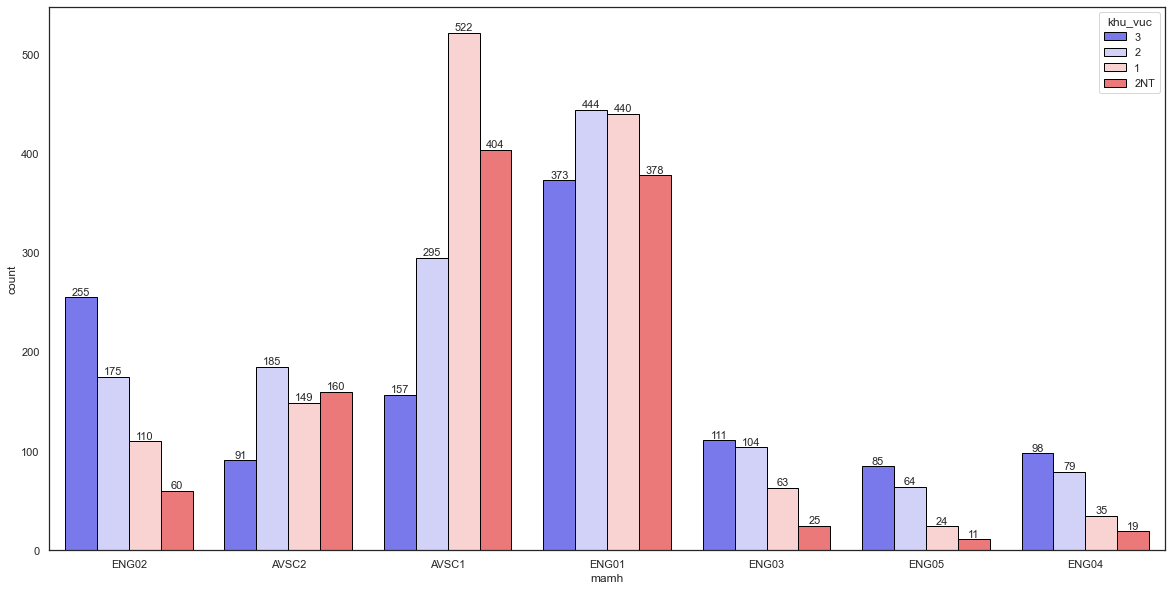

In [110]:
fig, ax = plt.subplots(figsize =(20, 10),facecolor=(1, 1, 1))

ax = sns.countplot(df1_copy['mamh'],data = df1,hue = df1_copy["khu_vuc"],palette = "bwr",edgecolor = 'black')

for rect in ax.patches:
    if math.isnan(rect.get_height()) : continue
    
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, int(rect.get_height()), horizontalalignment='center', fontsize = 11)

Thuộc tính khu vực có ảnh hưởng đến kết quả thi anh văn đầu vào của sinh viên (mamh). Khi các sinh viên thuộc khu vực 3 (không được cộng điểm ưu tiên) rất giỏi tiếng anh khi phần lớn đều đạt ENG01 trở lên. Ngược lại các bạn khu vực 1 (cộng nhiều điểm ưu tiên nhất) thường học anh văn không tốt bằng các khu vực khác

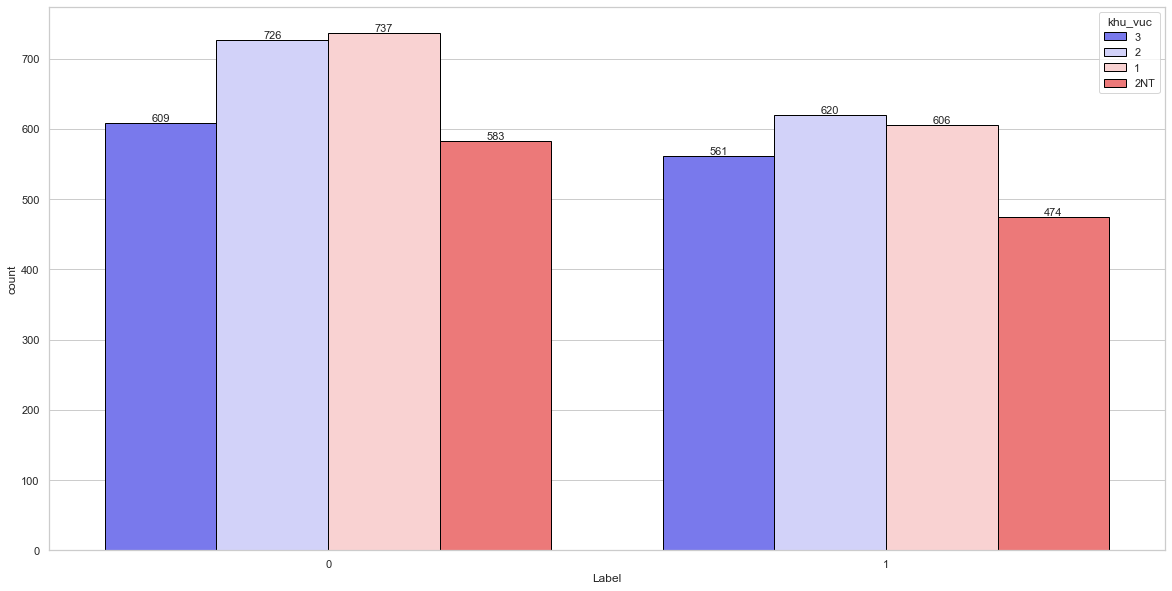

In [77]:
countplot(df1_copy,"khu_vuc")

Tuy khu vực ảnh hưởng đến kết quả thi anh văn đầu vào, nhưng đến dường như thuộc tính này lại không ảnh hưởng đến việc các bạn có đạt chuẩn quá trình hay không khi tỉ lệ giữa các khu vực đều tương tự nhau (~50%). Lí do có thể là khi các bạn đều học cùng một nơi thì không có sự khác biệt về điều kiện học anh văn nên việc các bạn có đạt hay không đạt thì xác suất đều như nhau.

### Mối quan hệ của thuộc tính khoa đến nhãn

In [89]:
df1_copy["khoa"].value_counts()

HTTT      1118
MMT&TT    1063
CNPM       827
KHMT       753
KTMT       590
KTTT       565
Name: khoa, dtype: int64

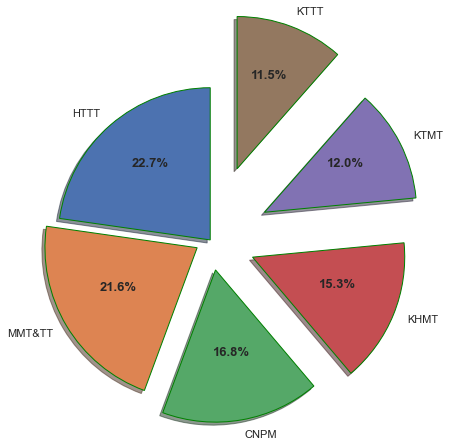

In [90]:
pie(df1_copy['khoa'],6)

Có tổng 6 khoa, với số lượng sinh viên nhiều nhất thuộc khoa HTTT và ít nhất là KTTT (chênh lệch gấp đôi)

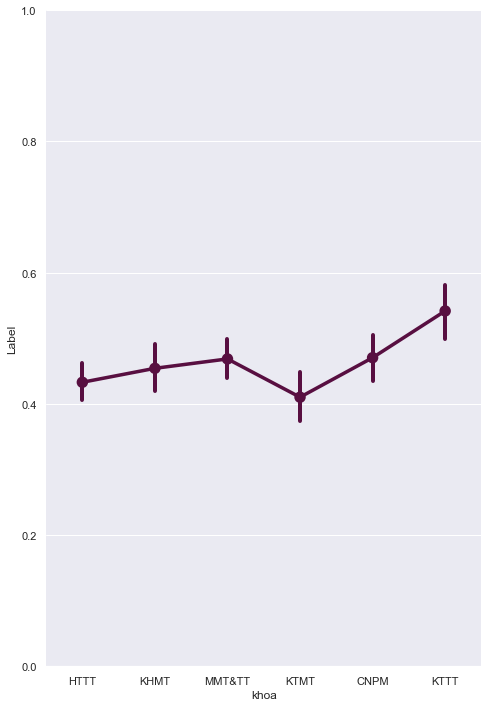

In [120]:
g = sns.PairGrid(df1_copy, y_vars="Label",
                 x_vars=["khoa"],
                 height=10, aspect=.7)


g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

Đồ thị trên thể hiện xác suất có đạt chuẩn quá trình anh văn với biến khoa.

Đối với mỗi khoa, tỉ lệ đều rơi vào cùng một khoảng xác suất xác định (40%-60%). Nếu chỉ tính riêng mỗi thuộc tính khoa thì sẽ không xuất hiện một xu hướng đặc biệt nào để có thể phân loại các nhãn. Ví dụ như có một khoa tỉ lệ đạt chỉ 10%, hay cao tới 80%.

Câu hỏi đặt ra là? Nếu khoa kết hợp với hệ đào tạo thì có thể xảy ra xu hướng nào cho dữ liệu không? Vì có những khoa có hệ đào tạo đặc biệt như tài năng mà những khoa khác không có

In [147]:
def create_y(arr):
    y = [0,0,0,0,0]
    if 'CQUI' in arr.index:
        y[0] = arr['CQUI']
    if 'CLC' in arr.index:
        y[1] = arr['CLC']
    if 'CTTT' in arr.index:
        y[2] = arr['CTTT']
    if 'KSTN' in arr.index:
        y[3] = arr['KSTN']
    if 'CNTN' in arr.index:
        y[4] = arr['CNTN']
    return y

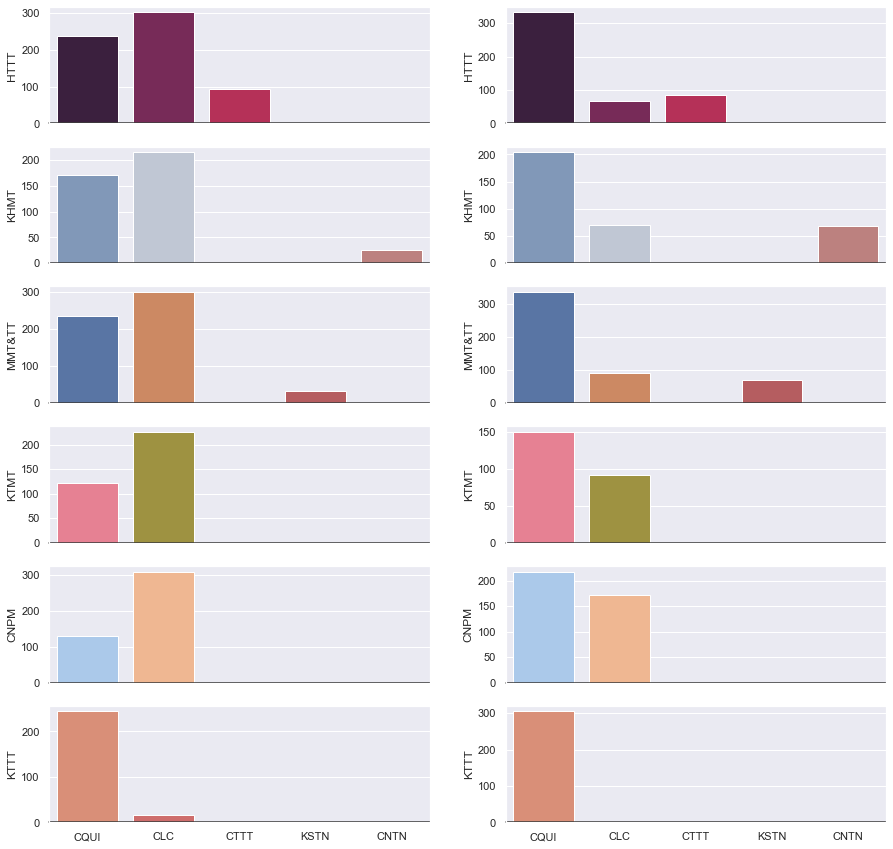

In [182]:
f, ax = plt.subplots(6, 2, figsize=(15, 15), sharex=True)
x = df1_copy['hedt'].unique()
khoa = ['HTTT','KHMT','MMT&TT','KTMT','CNPM','KTTT']

palette = ["rocket","vlag", "deep", "husl", "pastel", "flare"]

for i in ax:
    index =  np.where(ax == i)[0][0]
    label = 0
    for j in i:
        sns.barplot(x=x, y=create_y(df1_copy[(df1_copy['Label']== label) & (df1_copy['khoa']==khoa[index])]["hedt"].value_counts()), palette=palette[index], ax=j)
        j.axhline(0, color="k", clip_on=False)
        j.set_ylabel(khoa[index])
        label+=1


Đồ thị trên thống kê số lượng các sinh viên của các hệ đào tạo thuộc các khoa. Phía trên trái thuộc về nhãn 0 và bên phải thuộc về nhãn 1.

Dựa vào đồ thị ta nhìn thấy có một điểm chung giữa các khoa, đó là hệ CQUI sẽ có tỉ lệ đạt chuẩn quá trình AV cao hơn. Trong khi đó hệ CLC tỉ lệ này lại ngược lại. Vậy điều này cho thấy mối quan hệ của khoa và hệ đào tạo không ảnh hưởng gì đến output. Thuộc tính ảnh hưởng trong trường hợp này là hệ đào tạo. 

Tuy nhiên có một ngoại lệ, đó chính là khoa KTTT toàn hệ CLC đều nhãn 0. Nhưng số lượng này rất nhỏ (chưa đến 50 sinh viên) nên ta có thể bỏ qua trường hợp này. 

### Sự ảnh hưởng của giới tính

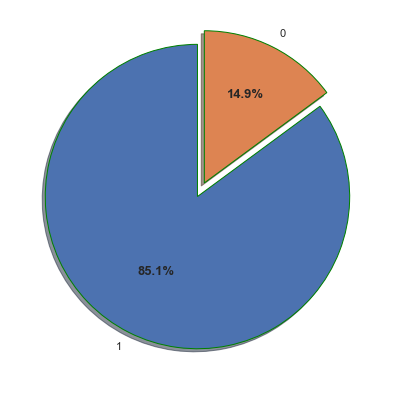

In [183]:
pie(df1_copy['gioitinh'],2)

Sinh viên nam chiếm phần lớn trong bộ dữ liệu

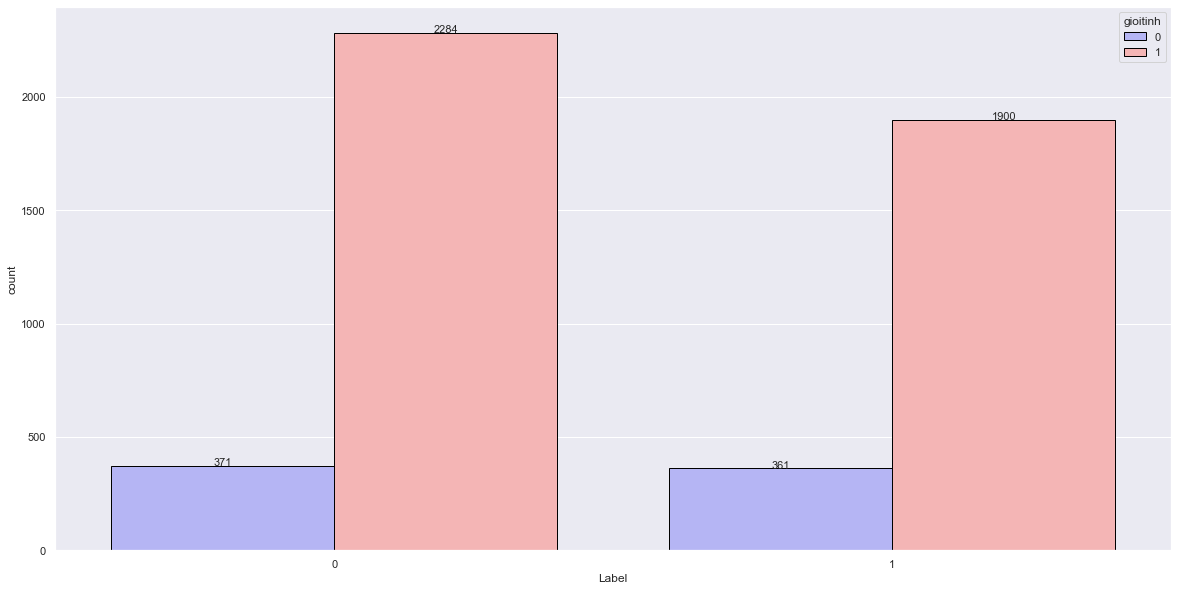

In [184]:
countplot(df1_copy,"gioitinh")

Tỉ lệ giới tính chia đều cho các nhãn (~50%)

### Mối tương quan giữa các biến

In [115]:
le = LabelEncoder()

df1_copy["mamh"] = le.fit_transform(df1_copy[["mamh"]])
df1_copy["khu_vuc"] = le.fit_transform(df1_copy[["khu_vuc"]].astype(str))
df1_copy["gioitinh"] = le.fit_transform(df1_copy[["gioitinh"]])
df1_copy["khoa"] = le.fit_transform(df1_copy[["khoa"]])
df1_copy["hedt"] = le.fit_transform(df1_copy[["hedt"]])
df1_copy["dien_tt"] = le.fit_transform(df1_copy[["dien_tt"]])

Text(156.453125, 0.5, '')

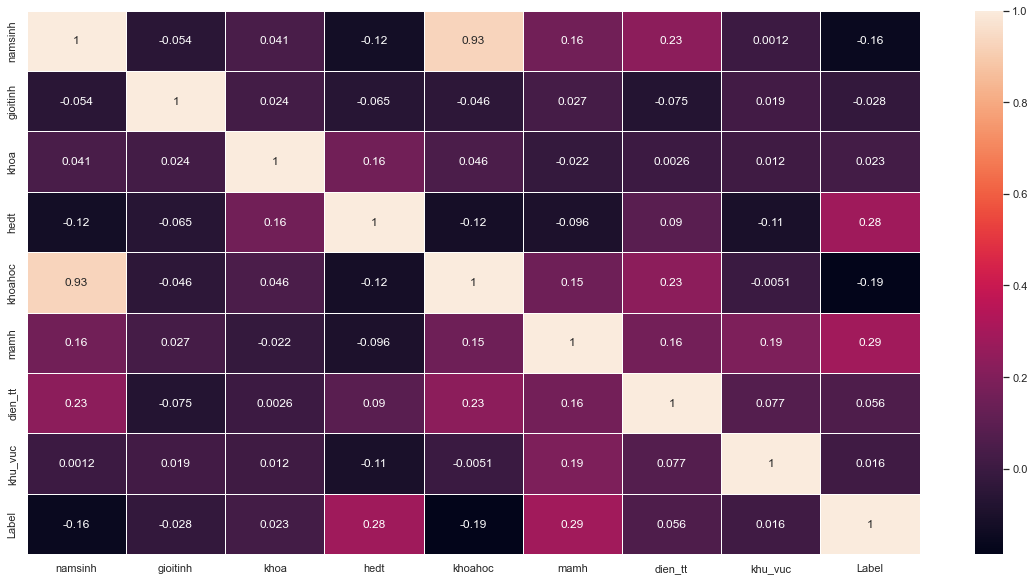

In [118]:
f, ax = plt.subplots(figsize=(20, 10))
correlations=df1_copy.convert_dtypes().corr()
sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")

Từ đồ thị tương quan, ta thấy rằng các biến sau đây có mối quan hệ mạnh với Label: namsinh, hedt, khoahoc, mamh.

Còn lại còn biến: gioitinh, khoa, dien_tt, khu_vuc lại dường như rất ít ảnh hưởng với Label.

Dựa vào những phân tích trên và đồ thị tương quan, ta sẽ xóa các biến gioitinh, khoa, dien_tt, khu_vuc khỏi dataset vì các biến này không có giá trị trong việc dự đoán.


## Xây dựng mô hình

Đầu tiên ta cần mã hóa các thuộc tính 

Với các thuộc tính hedt, dien_tt, khoa không có tính thứ tự, nên sẽ dùng mã hóa One-Hot.

Riêng thuộc tính mamh, khu_vuc mang tính thứ tự nên sẽ dùng Label Encoder.

In [13]:
df1

,namsinh,gioitinh,khoa,hedt,khoahoc,mamh,dien_tt,khu_vuc,Label
1,1996,1,HTTT,CQUI,9,ENG02,THPT,3,0
2,1996,1,KHMT,CQUI,9,AVSC2,THPT,3,1
3,1996,1,KHMT,CQUI,10,AVSC1,THPT,3,0
4,1995,1,MMT&TT,CQUI,10,AVSC1,THPT,3,0
5,1997,1,KTMT,CLC,10,AVSC2,THPT,3,0
...,...,...,...,...,...,...,...,...,...
4912,2001,1,HTTT,CLC,14,AVSC1,THPT,2,0
4913,2001,0,KHMT,CQUI,14,AVSC1,THPT,2,0
4914,2001,0,HTTT,CLC,14,AVSC1,THPT,2NT,0
4915,2001,0,HTTT,CQUI,14,AVSC2,THPT,2,0


In [12]:
mamh = ['AVSC1', 'AVSC2', 'ENG01', 'ENG02', 'ENG03', 'ENG04', 'ENG05']
khuvuc = ['1','2NT','2','3']

### Sử dụng tất cả thuộc tính

In [145]:
df_all1=df1.convert_dtypes().drop(columns=["Label"])
dfy = df1["Label"]

In [146]:
le = LabelEncoder()
le.fit(mamh)
df_all1["mamh"] = le.fit_transform(df_all1[["mamh"]])
le.fit(khuvuc)
df_all1["khu_vuc"] = le.fit_transform(df_all1[["khu_vuc"]].astype(str))

c:\Users\PC\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\PC\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [147]:
df_all1 = pd.get_dummies(df_all1, columns=["hedt","dien_tt","khoa"])

In [148]:
data = df_all1.values

X = data[:, :]
y = dfy.values.astype(int)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,
                                             random_state = 42)

#### Models

##### Logistic

In [226]:
logis = Logistic()
logis.grid_search(xtrain,ytrain)

In [227]:
logis.kfold(xtrain,ytrain)
print(classification_report(logis.predict(xtest), ytest))

k: 0, train acc: 0.7244979919678715, and validation acc: 0.751269035532995
k: 1, train acc: 0.7282463186077643, and validation acc: 0.6395939086294417
k: 2, train acc: 0.7167336010709505, and validation acc: 0.7157360406091371
k: 3, train acc: 0.7218206157965195, and validation acc: 0.7208121827411168
k: 4, train acc: 0.7188755020080321, and validation acc: 0.751269035532995
k: 5, train acc: 0.7207496653279786, and validation acc: 0.7106598984771574
k: 6, train acc: 0.7204819277108434, and validation acc: 0.7055837563451777
k: 7, train acc: 0.7223560910307898, and validation acc: 0.7208121827411168
k: 8, train acc: 0.7145917001338689, and validation acc: 0.7461928934010152
k: 9, train acc: 0.7226238286479251, and validation acc: 0.7411167512690355
k: 10, train acc: 0.7231593038821954, and validation acc: 0.7157360406091371
k: 11, train acc: 0.7220883534136546, and validation acc: 0.6852791878172588
k: 12, train acc: 0.7200214132762313, and validation acc: 0.7295918367346939
k: 13, trai

##### SVM

In [231]:
svm = SVM()
svm.grid_search(xtrain,ytrain)

In [232]:
svm.kfold(xtrain,ytrain)
print(classification_report(svm.predict(xtest), ytest))

k: 0, train acc: 0.7121820615796519, and validation acc: 0.7614213197969543
k: 1, train acc: 0.7196787148594378, and validation acc: 0.6395939086294417
k: 2, train acc: 0.7153949129852745, and validation acc: 0.7208121827411168
k: 3, train acc: 0.7170013386880857, and validation acc: 0.7258883248730964
k: 4, train acc: 0.7145917001338689, and validation acc: 0.7157360406091371
k: 5, train acc: 0.7153949129852745, and validation acc: 0.7106598984771574
k: 6, train acc: 0.7156626506024096, and validation acc: 0.6903553299492385
k: 7, train acc: 0.7140562248995984, and validation acc: 0.7411167512690355
k: 8, train acc: 0.7124497991967872, and validation acc: 0.7614213197969543
k: 9, train acc: 0.7143239625167336, and validation acc: 0.7309644670050761
k: 10, train acc: 0.7172690763052209, and validation acc: 0.6852791878172588
k: 11, train acc: 0.7191432396251674, and validation acc: 0.6852791878172588
k: 12, train acc: 0.713865096359743, and validation acc: 0.7448979591836735
k: 13, tra

##### AdaBoost

In [236]:
ada = Adaboost()
ada.grid_search(xtrain,ytrain)

In [237]:
ada.kfold(xtrain,ytrain)
print(classification_report(ada.predict(xtest), ytest))

k: 0, train acc: 0.8519410977242302, and validation acc: 0.6954314720812182
k: 1, train acc: 0.8546184738955823, and validation acc: 0.6598984771573604
k: 2, train acc: 0.8508701472556894, and validation acc: 0.7360406091370558
k: 3, train acc: 0.8519410977242302, and validation acc: 0.7157360406091371
k: 4, train acc: 0.8532797858099063, and validation acc: 0.6954314720812182
k: 5, train acc: 0.8522088353413655, and validation acc: 0.6954314720812182
k: 6, train acc: 0.8527443105756358, and validation acc: 0.6852791878172588
k: 7, train acc: 0.8538152610441767, and validation acc: 0.6802030456852792
k: 8, train acc: 0.851673360107095, and validation acc: 0.7715736040609137
k: 9, train acc: 0.8514056224899599, and validation acc: 0.7258883248730964
k: 10, train acc: 0.8522088353413655, and validation acc: 0.6852791878172588
k: 11, train acc: 0.8540829986613119, and validation acc: 0.6598984771573604
k: 12, train acc: 0.8503747323340471, and validation acc: 0.7397959183673469
k: 13, tra

##### MLP 

In [242]:
mlp = MLP()
mlp.grid_search(xtrain,ytrain)

In [243]:
mlp.kfold(xtrain,ytrain)
print(classification_report(mlp.predict(xtest), ytest))

k: 0, train acc: 0.7111111111111111, and validation acc: 0.7614213197969543
k: 1, train acc: 0.7215528781793842, and validation acc: 0.649746192893401
k: 2, train acc: 0.7164658634538152, and validation acc: 0.7360406091370558
k: 3, train acc: 0.7172690763052209, and validation acc: 0.7360406091370558
k: 4, train acc: 0.7129852744310575, and validation acc: 0.7258883248730964
k: 5, train acc: 0.7175368139223561, and validation acc: 0.7106598984771574
k: 6, train acc: 0.7172690763052209, and validation acc: 0.7106598984771574
k: 7, train acc: 0.7132530120481928, and validation acc: 0.7309644670050761
k: 8, train acc: 0.7140562248995984, and validation acc: 0.7715736040609137
k: 9, train acc: 0.7153949129852745, and validation acc: 0.7309644670050761
k: 10, train acc: 0.7244979919678715, and validation acc: 0.6751269035532995
k: 11, train acc: 0.7170013386880857, and validation acc: 0.6802030456852792
k: 12, train acc: 0.716541755888651, and validation acc: 0.7397959183673469
k: 13, trai

#### Kết quả trên tập test

In [245]:
res1 = pd.DataFrame({
    'Models Used': ['LogisticRegression', 
                    'Support Vector Machine', 
                    'AdaBoost',
                    'MLP'],
    'Accuracy': [accuracy_score(logis.predict(xtest), ytest)*100,
                             accuracy_score(svm.predict(xtest), ytest)*100,
                             accuracy_score(ada.predict(xtest), ytest)*100,
                             accuracy_score(mlp.predict(xtest), ytest)*100],
    'Precision': [precision_score(logis.predict(xtest), ytest)*100,
                             precision_score(svm.predict(xtest), ytest)*100,
                             precision_score(ada.predict(xtest), ytest)*100,
                             precision_score(mlp.predict(xtest), ytest)*100],
    'Recall': [recall_score(logis.predict(xtest), ytest)*100,
                            recall_score(svm.predict(xtest), ytest)*100,
                            recall_score(ada.predict(xtest), ytest)*100,
                            recall_score(mlp.predict(xtest), ytest)*100],
    'F1': [f1_score(logis.predict(xtest), ytest)*100,
                            f1_score(svm.predict(xtest), ytest)*100,
                            f1_score(ada.predict(xtest), ytest)*100,
                            f1_score(mlp.predict(xtest), ytest)*100]
})
res1.head()

,Models Used,Accuracy,Precision,Recall,F1
0,LogisticRegression,69.817073,72.160356,65.322581,68.571429
1,Support Vector Machine,70.731707,66.815145,68.337130,67.567568
2,AdaBoost,69.918699,68.596882,66.522678,67.543860
3,MLP,70.731707,66.146993,68.591224,67.346939


### Sử dụng các thuộc tính đã phân tích

In [14]:
df_notall1=df1.convert_dtypes().drop(columns=["Label","khu_vuc","dien_tt","khoa","gioitinh"])
dfy = df1["Label"]

In [16]:
le = LabelEncoder()
le.fit(mamh)
df_notall1["mamh"] = le.fit_transform(df_notall1[["mamh"]])


In [17]:
df_notall1 = pd.get_dummies(df_notall1, columns=["hedt"])

In [18]:
data = df_notall1.values

X = data[:, :]
y = dfy.values.astype(int)

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,
                                             random_state = 42)

#### Models

##### Logistic

In [20]:
logis = Logistic()
logis.grid_search(xtrain,ytrain)

In [21]:
logis.kfold(xtrain,ytrain)
print(classification_report(logis.predict(xtest), ytest))

k: 0, train acc: 0.7247657295850067, and validation acc: 0.751269035532995
k: 1, train acc: 0.730388219544846, and validation acc: 0.6345177664974619
k: 2, train acc: 0.7231593038821954, and validation acc: 0.7106598984771574
k: 3, train acc: 0.7247657295850067, and validation acc: 0.7563451776649747
k: 4, train acc: 0.7223560910307898, and validation acc: 0.7360406091370558
k: 5, train acc: 0.7239625167336011, and validation acc: 0.7055837563451777
k: 6, train acc: 0.7261044176706827, and validation acc: 0.7208121827411168
k: 7, train acc: 0.7266398929049531, and validation acc: 0.7208121827411168
k: 8, train acc: 0.7236947791164658, and validation acc: 0.766497461928934
k: 9, train acc: 0.7258366800535475, and validation acc: 0.7461928934010152
k: 10, train acc: 0.7269076305220884, and validation acc: 0.700507614213198
k: 11, train acc: 0.7287817938420348, and validation acc: 0.6751269035532995
k: 12, train acc: 0.7248394004282656, and validation acc: 0.75
k: 13, train acc: 0.7224304

##### SVM

In [29]:
svm = SVM()
svm.grid_search(xtrain,ytrain)

In [30]:
svm.kfold(xtrain,ytrain)
print(classification_report(svm.predict(xtest), ytest))

k: 0, train acc: 0.7215528781793842, and validation acc: 0.7461928934010152
k: 1, train acc: 0.7325301204819277, and validation acc: 0.6598984771573604
k: 2, train acc: 0.7285140562248996, and validation acc: 0.7360406091370558
k: 3, train acc: 0.7279785809906292, and validation acc: 0.7461928934010152
k: 4, train acc: 0.727710843373494, and validation acc: 0.751269035532995
k: 5, train acc: 0.7285140562248996, and validation acc: 0.7360406091370558
k: 6, train acc: 0.7298527443105757, and validation acc: 0.7106598984771574
k: 7, train acc: 0.7287817938420348, and validation acc: 0.7309644670050761
k: 8, train acc: 0.7218206157965195, and validation acc: 0.7411167512690355
k: 9, train acc: 0.7271753681392236, and validation acc: 0.7614213197969543
k: 10, train acc: 0.7301204819277108, and validation acc: 0.7055837563451777
k: 11, train acc: 0.7301204819277108, and validation acc: 0.7055837563451777
k: 12, train acc: 0.7221627408993576, and validation acc: 0.7346938775510204
k: 13, trai

##### AdaBoost

In [31]:
ada = Adaboost()
ada.grid_search(xtrain,ytrain)

In [32]:
ada.kfold(xtrain,ytrain)
print(classification_report(ada.predict(xtest), ytest))

k: 0, train acc: 0.765194109772423, and validation acc: 0.7614213197969543
k: 1, train acc: 0.7700133868808567, and validation acc: 0.6903553299492385
k: 2, train acc: 0.7662650602409639, and validation acc: 0.7461928934010152
k: 3, train acc: 0.7670682730923695, and validation acc: 0.751269035532995
k: 4, train acc: 0.766532797858099, and validation acc: 0.7461928934010152
k: 5, train acc: 0.7659973226238287, and validation acc: 0.7563451776649747
k: 6, train acc: 0.7662650602409639, and validation acc: 0.7411167512690355
k: 7, train acc: 0.7662650602409639, and validation acc: 0.7563451776649747
k: 8, train acc: 0.7633199464524766, and validation acc: 0.817258883248731
k: 9, train acc: 0.7649263721552878, and validation acc: 0.7766497461928934
k: 10, train acc: 0.768942436412316, and validation acc: 0.7157360406091371
k: 11, train acc: 0.7678714859437751, and validation acc: 0.7258883248730964
k: 12, train acc: 0.765524625267666, and validation acc: 0.7704081632653061
k: 13, train ac

##### MLP

In [33]:
mlp = MLP()
mlp.grid_search(xtrain,ytrain)

In [34]:
mlp.kfold(xtrain,ytrain)
print(classification_report(mlp.predict(xtest), ytest))

k: 0, train acc: 0.7170013386880857, and validation acc: 0.766497461928934
k: 1, train acc: 0.7226238286479251, and validation acc: 0.6598984771573604
k: 2, train acc: 0.7215528781793842, and validation acc: 0.7360406091370558
k: 3, train acc: 0.7215528781793842, and validation acc: 0.7360406091370558
k: 4, train acc: 0.7188755020080321, and validation acc: 0.7309644670050761
k: 5, train acc: 0.7236947791164658, and validation acc: 0.7106598984771574
k: 6, train acc: 0.7223560910307898, and validation acc: 0.7157360406091371
k: 7, train acc: 0.7183400267737617, and validation acc: 0.7411167512690355
k: 8, train acc: 0.7194109772423025, and validation acc: 0.7715736040609137
k: 9, train acc: 0.7191432396251674, and validation acc: 0.7258883248730964
k: 10, train acc: 0.7247657295850067, and validation acc: 0.6852791878172588
k: 11, train acc: 0.7255689424364123, and validation acc: 0.6751269035532995
k: 12, train acc: 0.7181477516059958, and validation acc: 0.7448979591836735
k: 13, tra

#### Kết quả trên tập test

In [35]:
res1 = pd.DataFrame({
    'Models Used': ['LogisticRegression', 
                    'Support Vector Machine', 
                    'AdaBoost',
                    'MLP'],
    'Accuracy': [accuracy_score(logis.predict(xtest), ytest)*100,
                             accuracy_score(svm.predict(xtest), ytest)*100,
                             accuracy_score(ada.predict(xtest), ytest)*100,
                             accuracy_score(mlp.predict(xtest), ytest)*100],
    'Precision': [precision_score(logis.predict(xtest), ytest)*100,
                             precision_score(svm.predict(xtest), ytest)*100,
                             precision_score(ada.predict(xtest), ytest)*100,
                             precision_score(mlp.predict(xtest), ytest)*100],
    'Recall': [recall_score(logis.predict(xtest), ytest)*100,
                            recall_score(svm.predict(xtest), ytest)*100,
                            recall_score(ada.predict(xtest), ytest)*100,
                            recall_score(mlp.predict(xtest), ytest)*100],
    'F1': [f1_score(logis.predict(xtest), ytest)*100,
                            f1_score(svm.predict(xtest), ytest)*100,
                            f1_score(ada.predict(xtest), ytest)*100,
                            f1_score(mlp.predict(xtest), ytest)*100]
})
res1.head()

,Models Used,Accuracy,Precision,Recall,F1
0,LogisticRegression,72.154472,73.719376,67.967146,70.726496
1,Support Vector Machine,71.443089,66.146993,69.718310,67.885714
2,AdaBoost,72.764228,66.815145,71.599045,69.124424
3,MLP,71.951220,68.151448,69.703872,68.918919


# Có Thông Tin Anh Văn

In [120]:
wb = openpyxl.load_workbook('./data_final.xlsx',keep_vba=True, data_only=True)
sheet = wb[wb.sheetnames[0]]
df2 = pd.DataFrame(data=sheet.values)
df2.columns = df2.iloc[0]
df2 = df2[1:]
df2 = df2.drop(columns=['mssv'])

In [121]:
df2

,namsinh,gioitinh,khoa,hedt,khoahoc,mamh,dien_tt,khu_vuc,chuanav_1,Label
1,1996,1,HTTT,CQUI,9,ENG02,THPT,3,ENG02,0
2,1996,1,KHMT,CQUI,9,AVSC2,THPT,3,AVSC2,1
3,1996,1,KHMT,CQUI,10,AVSC1,THPT,3,ENG01,0
4,1995,1,MMT&TT,CQUI,10,AVSC1,THPT,3,AVSC1,0
5,1997,1,KTMT,CLC,10,AVSC2,THPT,3,AVSC2,0
...,...,...,...,...,...,...,...,...,...,...
4912,2001,1,HTTT,CLC,14,AVSC1,THPT,2,AVSC1,0
4913,2001,0,KHMT,CQUI,14,AVSC1,THPT,2,ENG01,0
4914,2001,0,HTTT,CLC,14,AVSC1,THPT,2NT,AVSC2,0
4915,2001,0,HTTT,CQUI,14,AVSC2,THPT,2,ENG01,0


In [125]:
df2_copy = df2.copy()

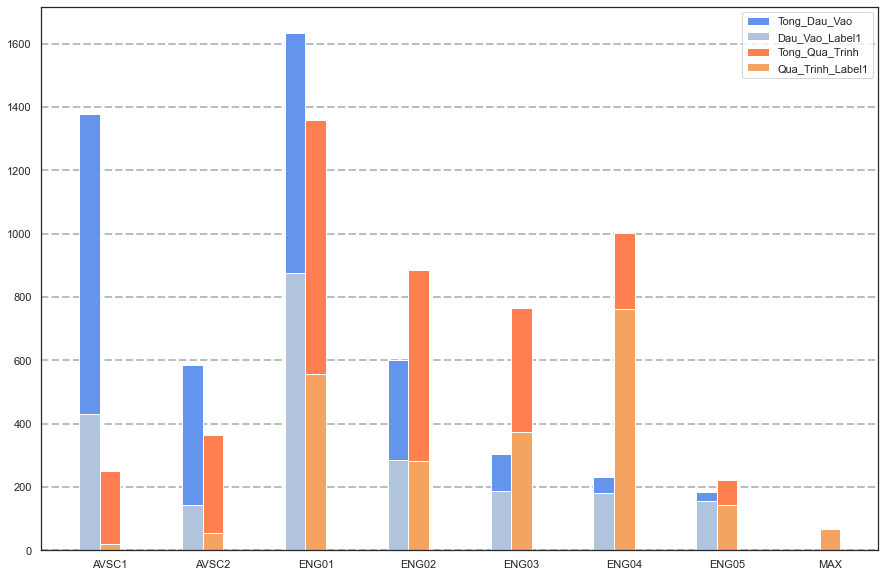

In [160]:
width = 0.2
fig = plt.figure(figsize = (15, 10))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.bar(np.arange(len(df2_copy["mamh"].value_counts())),df2_copy["mamh"].value_counts().sort_index(),width=width,label="Tong_Dau_Vao",color="cornflowerblue")
plt.bar(np.arange(len(df2_copy["mamh"].value_counts())),df2_copy[df2_copy["Label"]==1]["mamh"].value_counts().sort_index(),width=width,label="Dau_Vao_Label1",color="lightsteelblue")
plt.bar(np.arange(len(df2_copy["chuanav_1"].value_counts()))+width,df2_copy["chuanav_1"].value_counts().sort_index(),width=width,label="Tong_Qua_Trinh",color="coral")
plt.bar(np.arange(len(df2_copy["chuanav_1"].value_counts()))+width,df2_copy[df2_copy["Label"]==1]["chuanav_1"].value_counts().sort_index(),width=width,label="Qua_Trinh_Label1",color="sandybrown")
plt.xticks([r + width for r in range(len(df2_copy["chuanav_1"].value_counts()))],
    ["AVSC1", "AVSC2", "ENG01", "ENG02","ENG03","ENG04","ENG05","MAX"])

plt.legend()

Sự phân bố tiếng anh có sự thay đổi đáng kể. Có sự dịch chuyển rõ rệt khi các bạn thi đầu vào AVSC1 đã tăng bậc và dịch chuyển thành cột ENG01. Tương tự khi các bạn thi đầu vào được ENG01 đã phân bố lại thành ENG02, ENG03, ENG04. Điều này cho thấy sự hiệu quả trong quá trình học anh văn của các bạn sinh viên và chắc chắn sẽ ảnh hưởng đến nhãn cuối cùng của bài toán.

Ngoài ra, khi nhìn vào tỉ lệ label của các cột quá trình. Ta thấy rằng, khi các bạn đã học anh văn rồi (hoặc không học av) nhưng vẫn ở mức AVSC1, AVSC2, ENG01, ENG02 thì có tỉ lệ không đạt chuẩn rất cao ( AVSC1 gần như là tuyệt đối ).

In [123]:
le = LabelEncoder()

df2_copy["mamh"] = le.fit_transform(df2_copy[["mamh"]])
df2_copy["khu_vuc"] = le.fit_transform(df2_copy[["khu_vuc"]].astype(str))
df2_copy["gioitinh"] = le.fit_transform(df2_copy[["gioitinh"]])
df2_copy["khoa"] = le.fit_transform(df2_copy[["khoa"]])
df2_copy["hedt"] = le.fit_transform(df2_copy[["hedt"]])
df2_copy["dien_tt"] = le.fit_transform(df2_copy[["dien_tt"]])
df2_copy["chuanav_1"] = le.fit_transform(df2_copy[["chuanav_1"]])

Text(156.453125, 0.5, '')

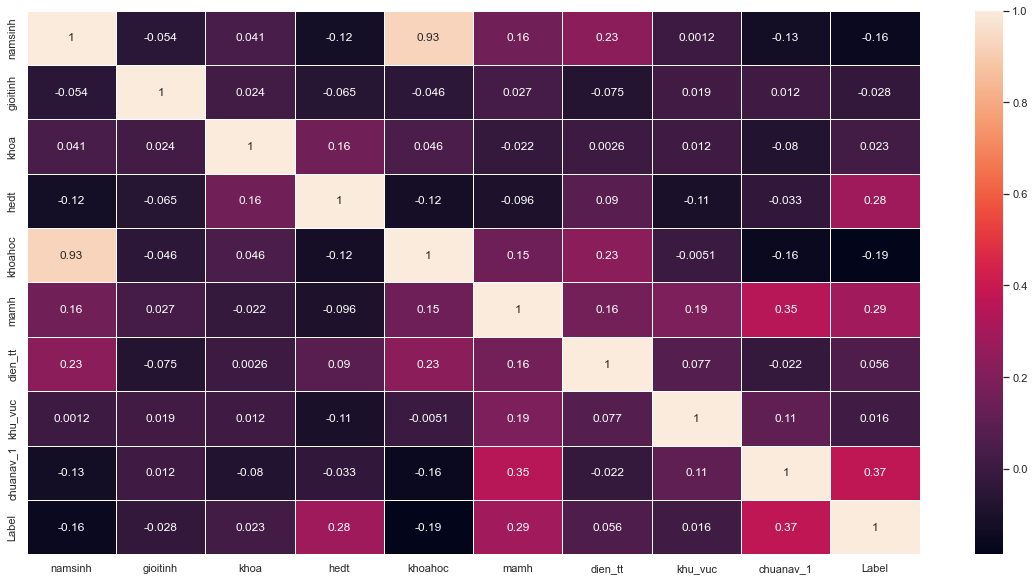

In [124]:
f, ax = plt.subplots(figsize=(20, 10))
correlations=df2_copy.convert_dtypes().corr()
sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")

Thuộc tính chuanav_1 có mối quan hệ rất mạnh mẽ với Label -> cải thiện tỉ lệ chính xác của mô hình.

## Models

In [36]:
mamh = ['AVSC1', 'AVSC2', 'ENG01', 'ENG02', 'ENG03', 'ENG04', 'ENG05']
khuvuc = ['1','2NT','2','3']
chuanav_1 = ['AVSC1', 'AVSC2', 'ENG01', 'ENG02', 'ENG03', 'ENG04', 'ENG05', 'ENG06']

### Sử dụng tất cả các thuộc tính

In [39]:
df_all2=df2.convert_dtypes().drop(columns=["Label"])
dfy = df2["Label"]

In [40]:
le = LabelEncoder()
le.fit(mamh)
df_all2["mamh"] = le.fit_transform(df_all2[["mamh"]])
le.fit(khuvuc)
df_all2["khu_vuc"] = le.fit_transform(df_all2[["khu_vuc"]].astype(str))
le.fit(khuvuc)
df_all2["chuanav_1"] = le.fit_transform(df_all2[["chuanav_1"]])

In [41]:
df_all2 = pd.get_dummies(df_all2, columns=["hedt","dien_tt","khoa"])

In [42]:
data = df_all2.values

X = data[:, :]
y = dfy.values.astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,
                                             random_state = 42)

#### Models

##### Logistic

In [43]:
logis = Logistic()
logis.grid_search(xtrain,ytrain)

In [44]:
logis.kfold(xtrain,ytrain)
print(classification_report(logis.predict(xtest), ytest))

k: 0, train acc: 0.7459170013386881, and validation acc: 0.7614213197969543
k: 1, train acc: 0.7528781793842034, and validation acc: 0.6548223350253807
k: 2, train acc: 0.7453815261044177, and validation acc: 0.766497461928934
k: 3, train acc: 0.7485943775100402, and validation acc: 0.766497461928934
k: 4, train acc: 0.7464524765729585, and validation acc: 0.7563451776649747
k: 5, train acc: 0.7472556894243642, and validation acc: 0.766497461928934
k: 6, train acc: 0.7488621151271754, and validation acc: 0.7157360406091371
k: 7, train acc: 0.7485943775100402, and validation acc: 0.7461928934010152
k: 8, train acc: 0.7421686746987952, and validation acc: 0.8578680203045685
k: 9, train acc: 0.7477911646586345, and validation acc: 0.7614213197969543
k: 10, train acc: 0.7499330655957162, and validation acc: 0.7208121827411168
k: 11, train acc: 0.7483266398929049, and validation acc: 0.7258883248730964
k: 12, train acc: 0.7467880085653105, and validation acc: 0.7448979591836735
k: 13, train

##### SVM

In [47]:
svm = SVM()
svm.grid_search(xtrain,ytrain)

In [48]:
svm.kfold(xtrain,ytrain)
print(classification_report(svm.predict(xtest), ytest))

k: 0, train acc: 0.7515394912985275, and validation acc: 0.7817258883248731
k: 1, train acc: 0.7544846050870148, and validation acc: 0.649746192893401
k: 2, train acc: 0.7504685408299866, and validation acc: 0.7715736040609137
k: 3, train acc: 0.7531459170013387, and validation acc: 0.7868020304568528
k: 4, train acc: 0.7499330655957162, and validation acc: 0.7563451776649747
k: 5, train acc: 0.7472556894243642, and validation acc: 0.7563451776649747
k: 6, train acc: 0.7526104417670683, and validation acc: 0.7208121827411168
k: 7, train acc: 0.7547523427041499, and validation acc: 0.7563451776649747
k: 8, train acc: 0.749665327978581, and validation acc: 0.8578680203045685
k: 9, train acc: 0.7504685408299866, and validation acc: 0.7563451776649747
k: 10, train acc: 0.7547523427041499, and validation acc: 0.7411167512690355
k: 11, train acc: 0.7493975903614458, and validation acc: 0.7309644670050761
k: 12, train acc: 0.7553533190578159, and validation acc: 0.75
k: 13, train acc: 0.74839

##### AdaBoost

In [49]:
ada = Adaboost()
ada.grid_search(xtrain,ytrain)

In [50]:
ada.kfold(xtrain,ytrain)
print(classification_report(ada.predict(xtest), ytest))

k: 0, train acc: 0.9095046854082999, and validation acc: 0.7868020304568528
k: 1, train acc: 0.9140562248995984, and validation acc: 0.6852791878172588
k: 2, train acc: 0.9103078982597055, and validation acc: 0.7817258883248731
k: 3, train acc: 0.908433734939759, and validation acc: 0.8020304568527918
k: 4, train acc: 0.9103078982597055, and validation acc: 0.766497461928934
k: 5, train acc: 0.9113788487282464, and validation acc: 0.7360406091370558
k: 6, train acc: 0.9113788487282464, and validation acc: 0.7157360406091371
k: 7, train acc: 0.9105756358768406, and validation acc: 0.7157360406091371
k: 8, train acc: 0.9100401606425703, and validation acc: 0.7715736040609137
k: 9, train acc: 0.9105756358768406, and validation acc: 0.7918781725888325
k: 10, train acc: 0.9116465863453815, and validation acc: 0.7614213197969543
k: 11, train acc: 0.9100401606425703, and validation acc: 0.751269035532995
k: 12, train acc: 0.9087259100642399, and validation acc: 0.8316326530612245
k: 13, train

##### MLP

In [51]:
mlp = MLP()
mlp.grid_search(xtrain,ytrain)

In [52]:
mlp.kfold(xtrain,ytrain)
print(classification_report(mlp.predict(xtest), ytest))

k: 0, train acc: 0.763855421686747, and validation acc: 0.7563451776649747
k: 1, train acc: 0.7630522088353414, and validation acc: 0.7157360406091371
k: 2, train acc: 0.7244979919678715, and validation acc: 0.7157360406091371
k: 3, train acc: 0.7336010709504686, and validation acc: 0.7309644670050761
k: 4, train acc: 0.7603748326639893, and validation acc: 0.7766497461928934
k: 5, train acc: 0.7646586345381526, and validation acc: 0.7411167512690355
k: 6, train acc: 0.7646586345381526, and validation acc: 0.7563451776649747
k: 7, train acc: 0.7228915662650602, and validation acc: 0.7208121827411168
k: 8, train acc: 0.7344042838018742, and validation acc: 0.817258883248731
k: 9, train acc: 0.7507362784471219, and validation acc: 0.766497461928934
k: 10, train acc: 0.7630522088353414, and validation acc: 0.7715736040609137
k: 11, train acc: 0.7614457831325301, and validation acc: 0.7411167512690355
k: 12, train acc: 0.7513383297644539, and validation acc: 0.7346938775510204
k: 13, train

#### Kết quả trên tập test

In [53]:
res1 = pd.DataFrame({
    'Models Used': ['LogisticRegression', 
                    'Support Vector Machine', 
                    'AdaBoost',
                    'MLP'],
    'Accuracy': [accuracy_score(logis.predict(xtest), ytest)*100,
                             accuracy_score(svm.predict(xtest), ytest)*100,
                             accuracy_score(ada.predict(xtest), ytest)*100,
                             accuracy_score(mlp.predict(xtest), ytest)*100],
    'Precision': [precision_score(logis.predict(xtest), ytest)*100,
                             precision_score(svm.predict(xtest), ytest)*100,
                             precision_score(ada.predict(xtest), ytest)*100,
                             precision_score(mlp.predict(xtest), ytest)*100],
    'Recall': [recall_score(logis.predict(xtest), ytest)*100,
                            recall_score(svm.predict(xtest), ytest)*100,
                            recall_score(ada.predict(xtest), ytest)*100,
                            recall_score(mlp.predict(xtest), ytest)*100],
    'F1': [f1_score(logis.predict(xtest), ytest)*100,
                            f1_score(svm.predict(xtest), ytest)*100,
                            f1_score(ada.predict(xtest), ytest)*100,
                            f1_score(mlp.predict(xtest), ytest)*100]
})
res1.head()

,Models Used,Accuracy,Precision,Recall,F1
0,LogisticRegression,72.662602,78.396437,67.175573,72.353546
1,Support Vector Machine,73.272358,77.282851,68.307087,72.518286
2,AdaBoost,74.898374,67.483296,75.000000,71.043376
3,MLP,75.203252,59.242762,81.345566,68.556701


### Sử dụng các thuộc tính đã phân tích

In [54]:
df_notall2=df1.convert_dtypes().drop(columns=["Label","khu_vuc","dien_tt","khoa","gioitinh"])
dfy = df1["Label"]

In [55]:
le = LabelEncoder()
le.fit(mamh)
df_notall2["mamh"] = le.fit_transform(df_notall1[["mamh"]])
le.fit(khuvuc)
df_notall2["chuanav_1"] = le.fit_transform(df_all2[["chuanav_1"]])


In [56]:
df_notall2 = pd.get_dummies(df_notall2, columns=["hedt"])

In [57]:
data = df_notall2.values

X = data[:, :]
y = dfy.values.astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,
                                             random_state = 42)

#### Models

##### Logistic

In [58]:
logis = Logistic()
logis.grid_search(xtrain,ytrain)

In [59]:
logis.kfold(xtrain,ytrain)
print(classification_report(logis.predict(xtest), ytest))

k: 0, train acc: 0.7507362784471219, and validation acc: 0.7715736040609137
k: 1, train acc: 0.7563587684069611, and validation acc: 0.6548223350253807
k: 2, train acc: 0.7523427041499331, and validation acc: 0.7563451776649747
k: 3, train acc: 0.7491298527443105, and validation acc: 0.7715736040609137
k: 4, train acc: 0.7512717536813922, and validation acc: 0.7715736040609137
k: 5, train acc: 0.7512717536813922, and validation acc: 0.7715736040609137
k: 6, train acc: 0.7531459170013387, and validation acc: 0.7208121827411168
k: 7, train acc: 0.7499330655957162, and validation acc: 0.7411167512690355
k: 8, train acc: 0.7448460508701472, and validation acc: 0.8730964467005076
k: 9, train acc: 0.7504685408299866, and validation acc: 0.7563451776649747
k: 10, train acc: 0.7528781793842034, and validation acc: 0.7208121827411168
k: 11, train acc: 0.7534136546184739, and validation acc: 0.7309644670050761
k: 12, train acc: 0.7516059957173448, and validation acc: 0.75
k: 13, train acc: 0.751

##### SVM

In [60]:
svm = SVM()
svm.grid_search(xtrain,ytrain)

In [61]:
svm.kfold(xtrain,ytrain)
print(classification_report(svm.predict(xtest), ytest))

k: 0, train acc: 0.7558232931726908, and validation acc: 0.8020304568527918
k: 1, train acc: 0.7617135207496654, and validation acc: 0.6751269035532995
k: 2, train acc: 0.7609103078982598, and validation acc: 0.7563451776649747
k: 3, train acc: 0.7603748326639893, and validation acc: 0.7817258883248731
k: 4, train acc: 0.7609103078982598, and validation acc: 0.766497461928934
k: 5, train acc: 0.7611780455153949, and validation acc: 0.751269035532995
k: 6, train acc: 0.7622489959839357, and validation acc: 0.7461928934010152
k: 7, train acc: 0.7611780455153949, and validation acc: 0.751269035532995
k: 8, train acc: 0.7552878179384204, and validation acc: 0.8223350253807107
k: 9, train acc: 0.7619812583668005, and validation acc: 0.7563451776649747
k: 10, train acc: 0.762516733601071, and validation acc: 0.7461928934010152
k: 11, train acc: 0.762516733601071, and validation acc: 0.7411167512690355
k: 12, train acc: 0.7609743040685225, and validation acc: 0.7551020408163265
k: 13, train a

##### AdaBoost

In [62]:
ada = Adaboost()
ada.grid_search(xtrain,ytrain)

In [63]:
ada.kfold(xtrain,ytrain)
print(classification_report(ada.predict(xtest), ytest))

k: 0, train acc: 0.8216867469879519, and validation acc: 0.7868020304568528
k: 1, train acc: 0.8246318607764391, and validation acc: 0.7411167512690355
k: 2, train acc: 0.8211512717536814, and validation acc: 0.7868020304568528
k: 3, train acc: 0.8195448460508702, and validation acc: 0.8324873096446701
k: 4, train acc: 0.8192771084337349, and validation acc: 0.8223350253807107
k: 5, train acc: 0.8214190093708166, and validation acc: 0.7918781725888325
k: 6, train acc: 0.8224899598393575, and validation acc: 0.7563451776649747
k: 7, train acc: 0.8203480589022758, and validation acc: 0.8121827411167513
k: 8, train acc: 0.8174029451137885, and validation acc: 0.8578680203045685
k: 9, train acc: 0.8198125836680054, and validation acc: 0.817258883248731
k: 10, train acc: 0.8211512717536814, and validation acc: 0.7969543147208121
k: 11, train acc: 0.8235609103078982, and validation acc: 0.751269035532995
k: 12, train acc: 0.8203961456102784, and validation acc: 0.8010204081632653
k: 13, trai

##### MLP

In [64]:
mlp = MLP()
mlp.grid_search(xtrain,ytrain)

In [65]:
mlp.kfold(xtrain,ytrain)
print(classification_report(mlp.predict(xtest), ytest))

k: 0, train acc: 0.7595716198125837, and validation acc: 0.7614213197969543
k: 1, train acc: 0.7552878179384204, and validation acc: 0.6903553299492385
k: 2, train acc: 0.749665327978581, and validation acc: 0.7208121827411168
k: 3, train acc: 0.7686746987951807, and validation acc: 0.8071065989847716
k: 4, train acc: 0.7451137884872825, and validation acc: 0.8071065989847716
k: 5, train acc: 0.7480589022757698, and validation acc: 0.7360406091370558
k: 6, train acc: 0.7453815261044177, and validation acc: 0.7309644670050761
k: 7, train acc: 0.7475234270414993, and validation acc: 0.7411167512690355
k: 8, train acc: 0.7413654618473896, and validation acc: 0.8071065989847716
k: 9, train acc: 0.7448460508701472, and validation acc: 0.7411167512690355
k: 10, train acc: 0.7641231593038822, and validation acc: 0.7766497461928934
k: 11, train acc: 0.7448460508701472, and validation acc: 0.7411167512690355
k: 12, train acc: 0.7441113490364025, and validation acc: 0.7551020408163265
k: 13, tra

#### Kết quả trên tập test

In [66]:
res1 = pd.DataFrame({
    'Models Used': ['LogisticRegression', 
                    'Support Vector Machine', 
                    'AdaBoost',
                    'MLP'],
    'Accuracy': [accuracy_score(logis.predict(xtest), ytest)*100,
                             accuracy_score(svm.predict(xtest), ytest)*100,
                             accuracy_score(ada.predict(xtest), ytest)*100,
                             accuracy_score(mlp.predict(xtest), ytest)*100],
    'Precision': [precision_score(logis.predict(xtest), ytest)*100,
                             precision_score(svm.predict(xtest), ytest)*100,
                             precision_score(ada.predict(xtest), ytest)*100,
                             precision_score(mlp.predict(xtest), ytest)*100],
    'Recall': [recall_score(logis.predict(xtest), ytest)*100,
                            recall_score(svm.predict(xtest), ytest)*100,
                            recall_score(ada.predict(xtest), ytest)*100,
                            recall_score(mlp.predict(xtest), ytest)*100],
    'F1': [f1_score(logis.predict(xtest), ytest)*100,
                            f1_score(svm.predict(xtest), ytest)*100,
                            f1_score(ada.predict(xtest), ytest)*100,
                            f1_score(mlp.predict(xtest), ytest)*100]
})
res1.head()

,Models Used,Accuracy,Precision,Recall,F1
0,LogisticRegression,73.272358,76.614699,68.525896,72.344900
1,Support Vector Machine,74.085366,71.937639,71.460177,71.698113
2,AdaBoost,77.845528,65.701559,82.172702,73.019802
3,MLP,73.780488,75.055679,69.772257,72.317597


# Visualize kết quả

Mục tiêu chính của nghiên cứu này sẽ giúp phòng đào tạo cảnh báo những trường hợp sinh viên sẽ không đạt chuẩn quá trình ngoại ngữ (label 0). So với label 1, ta sẽ ưu tiên việc dự đoán chính xác label 0 -> ngoài tỉ lệ accuracy,... ta cần quan tâm đến việc giảm thiểu trường hợp label là 0 nhưng ta lại dự đoán là 1 ( phòng đào tạo sẽ không cảnh báo ). Vì vậy ta cần ưu tiên các mô hình có độ precision cao.


In [30]:
acc1= [72.154472,71.443089,72.764228,71.951220]
pre1 = [73.719376,66.146993,66.815145,68.151448]
re1 = [67.967146,69.718310,71.599045,69.703872]
f1_1 = [70.726496,67.885714,69.124424,68.918919]

In [79]:
acc2= [73.272358,74.085366,77.845528,73.780488]
pre2 = [76.614699,71.937639,65.701559,75.055679]
re2 = [68.525896,71.460177,82.172702,69.772257]
f1_2 = [72.344900,71.698113,73.019802,72.317597]

In [77]:
def visualize(acc,pre,re,f1):
    width = 0.2
    fig = plt.figure(figsize = (15, 10))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.bar(np.arange(len(acc)),acc,width=width,label="Accuracy")
    plt.bar(np.arange(len(pre))+width,pre,width=width,label="Precision")
    plt.bar(np.arange(len(re))+2*width,re,width=width,label = "Recall")
    plt.bar(np.arange(len(f1))+3*width,f1,width=width, label = "F1")
    plt.xticks([r + 1.5*width for r in range(len(acc))],
       ["Logistic", "SVM", "Ada", "MLP"])
    
    plt.xlabel('Models', fontweight ='bold', fontsize = 15)
    plt.ylabel('%', fontweight ='bold', fontsize = 15)

    plt.legend()

    plt.show()

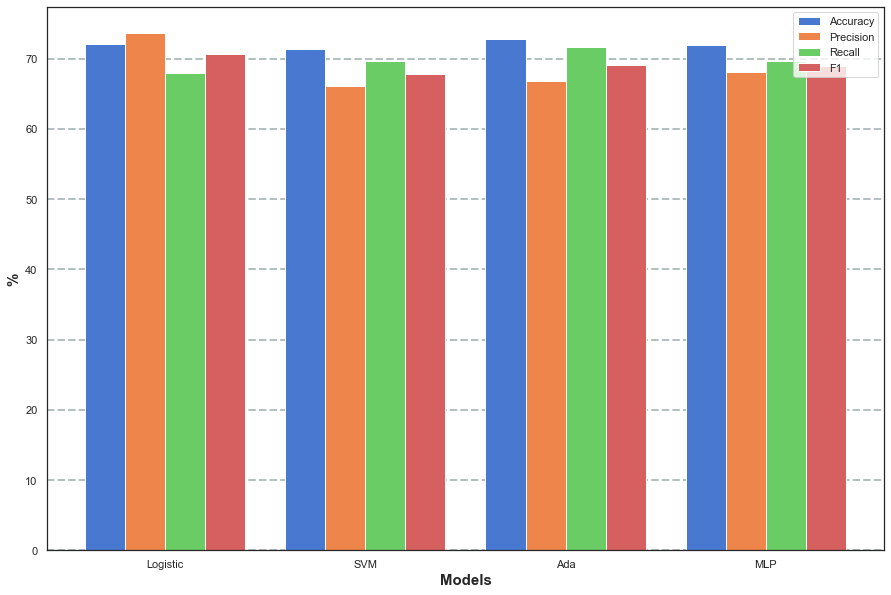

In [78]:
visualize(acc1,pre1,re1,f1_1)

Biểu độ so sánh các thang đo của 4 mô hình trước khi thêm thuộc tính chuẩn anh văn 1. 
- Accuracy: cao nhất là mô hình AdaBoost, tuy nhiên nhìn chung không có sự chênh lệnh rõ rệt giữa các mô hình (~1%)
- Precision: nhìn chung các mô hình đều thấp ở thang đo này ngoại trừ Logistic.
- Recall: có sự đánh đổi với precision, các mô hình thấp ở precision đều đạt recall cao.
- F1: chỉ có Logistic đạt ngưỡng 70%

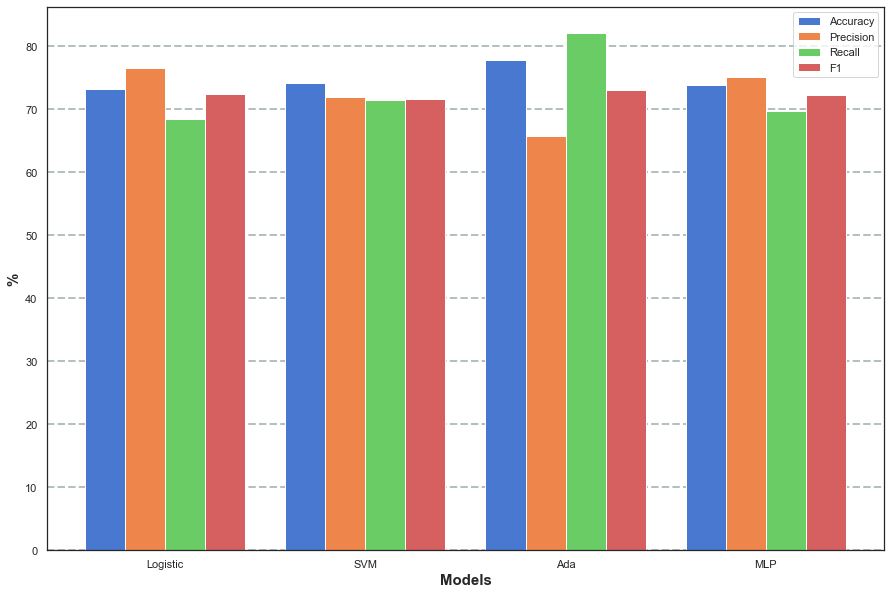

In [80]:
visualize(acc2,pre2,re2,f1_2)

Biểu độ so sánh các thang đo của 4 mô hình sau khi thêm thuộc tính chuẩn anh văn 1.
- Accuracy: có sự tăng lên rõ rệt khi Ada ~ 78% ( tăng gần 5% so với ban đầu ).
- Precision: phần lớn các mô hình đêu tăng precision, tuy nhiên Ada lại giảm.
- Recall: Ada đạt hơn 80%.
- F1: các mô hình nhìn chung không chêch lệnh với nhau


Kết luận: thuộc tính chuẩn anh văn 1 có ảnh hưởng đến hiệu quả của các mô hình. Hầu hết các chỉ số mô hình đều tăng đáng kể (~3% -> 5%). Dựa vào nhận định của nhóm, mô hình Logistic đạt hiệu quả cao nhất so với các mô hình còn lại, vì các chỉ số đều đạt mức ổn không thấp hơn quá nhiều và đạt được sự ổn định ở thang đo precision. Riêng với trường hợp Ada, do tỉ lệ của precision quá thấp (~65%) nên mô hình này có xu hướng sẽ dự đoán các sinh viên chưa đạt chuẩn thành đạt chuẩn cao.